# Eksploracja danych - zbiór `listings.csv`

Wstępny przegląd danych z pierwszej paczki

## Wnioski

* Ponad 80% ocen zawiera się między 4.5 a 5.0

In [3]:
from datetime import datetime

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression


In [4]:
DATA_DIR = "data"

In [5]:
def get_listings():
    return pd.read_csv(f'../{ DATA_DIR }/raw/listings.csv')

## Wielkość zbioru danych

In [6]:
listings = get_listings()
total_len = len(listings)

review_columns = [
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
]
listings_with_reviews = listings[listings[review_columns].notna().any(axis=1)]
len_with_reviews = len(listings_with_reviews)

print(f"Liczba przykładów w całym zbiorze {total_len}")
print(f"Liczba przykładów z oceną {len_with_reviews}")

Liczba przykładów w całym zbiorze 13984
Liczba przykładów z oceną 10706


## Atrybuty

In [7]:
listings = get_listings()
listings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2084992,https://www.nocarz.pl/rooms/2084992,20241221052002,2024-12-21,previous scrape,"Nice and cozy apartment in Kreuzberg, Graefekiez",Our cosy two room Apartment (70qm) in a vibrat...,"The apartment is situated on Fichtestrasse, wh...",https://a0.muscache.com/pictures/c4f2a8a8-34fa...,6302373,...,5.00,4.64,4.82,NaN,f,1,1,0,0,0.09
1,1123383729460847373,https://www.nocarz.pl/rooms/1123383729460847373,20241221052002,2024-12-21,city scrape,Furnished room in well equipped serviced apart...,Room in an apartment available. Apartment has ...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,206488801,...,NaN,NaN,NaN,NaN,f,3,1,2,0,NaN
2,1205255838613758737,https://www.nocarz.pl/rooms/1205255838613758737,20241221052002,2024-12-21,city scrape,Luxurous game room with private bath in X-Berg,Cozy private room in Berlin Mitte with private...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,50009901,...,4.97,4.94,4.94,01/Z/AZ/017416-24,f,1,0,1,0,9.53
3,8164759,https://www.nocarz.pl/rooms/8164759,20241221052002,2024-12-21,previous scrape,Beautiful single-room studio,Experience the “real Berlin” in our small and ...,In the area you can find lots of affordable ba...,https://a0.muscache.com/pictures/103988560/a5d...,42115726,...,5.00,3.00,3.00,NaN,f,1,1,0,0,0.01
4,18836877,https://www.nocarz.pl/rooms/18836877,20241221052002,2024-12-21,previous scrape,Unterkunft zentral in Berlin,"The accommodation has 3 rooms, however, is onl...",NaN,https://a0.muscache.com/pictures/452bf022-c9a9...,131184702,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN


In [8]:
for c in listings.columns: print(c)

id
listing_url
scrape_id
last_scraped
source
name
description
neighborhood_overview
picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
latitude
longitude
property_type
room_type
accommodates
bathrooms
bathrooms_text
bedrooms
beds
amenities
price
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_nights_avg_ntm
maximum_nights_avg_ntm
calendar_updated
has_availability
availability_30
availability_60
availability_90
availability_365
calendar_last_scraped
number_of_reviews
number_of_reviews_ltm
number_of_reviews_l30d
first_review
last_review
review_scores_rating
review_scores_accuracy
re

## Nieprzydatne atrybuty

In [9]:
def drop_useless_columns(df):
    cols_to_drop = [
        "id",
        "listing_url",
        "scrape_id",
        "last_scraped",
        "source",
        "picture_url",
        "host_name",
        "host_url",
        "host_thumbnail_url",
        "host_picture_url",
        "calendar_last_scraped",
        "calendar_updated",  # only missing values
        "neighbourhood",
        "host_location",
        "host_neighbourhood",
        "neighbourhood_cleansed",
        "number_of_reviews",
        "number_of_reviews_ltm",
        "number_of_reviews_l30d",
        "first_review",  # will not be present in new offers
        "last_review",  # will not be present in new offers
        "latitude",  # neighbourhood category should be more informative
        "longitude",  # neighbourhood category should be more informative
        "amenities",
        # this could be useful but has too many categories (1000+), maybe use one-hot encoding + embeddings?
        "reviews_per_month",  # will be missing for new offers
    ]

    return df.drop(columns=cols_to_drop)

In [10]:
# Count missing values
# listings = get_listings()
# cols = [
#     "picture_url",
#     "host_url",
#     "host_thumbnail_url",
#     "host_picture_url",
#     "calendar_updated"
# ]
for col in listings.columns:
    null_count = listings[col].isna().sum()
    if null_count > 0:
        print(f"{col} missing: {null_count} ({round(null_count / len(listings), 2) * 100}%)")


description missing: 619 (4.0%)
neighborhood_overview missing: 7193 (51.0%)
host_name missing: 9 (0.0%)
host_since missing: 9 (0.0%)
host_location missing: 2659 (19.0%)
host_about missing: 6791 (49.0%)
host_response_time missing: 5328 (38.0%)
host_response_rate missing: 5328 (38.0%)
host_acceptance_rate missing: 4537 (32.0%)
host_is_superhost missing: 137 (1.0%)
host_thumbnail_url missing: 9 (0.0%)
host_picture_url missing: 9 (0.0%)
host_neighbourhood missing: 7887 (56.00000000000001%)
host_listings_count missing: 9 (0.0%)
host_total_listings_count missing: 9 (0.0%)
host_verifications missing: 9 (0.0%)
host_has_profile_pic missing: 9 (0.0%)
host_identity_verified missing: 9 (0.0%)
neighbourhood missing: 7193 (51.0%)
bathrooms missing: 4982 (36.0%)
bathrooms_text missing: 7 (0.0%)
bedrooms missing: 2060 (15.0%)
beds missing: 5013 (36.0%)
price missing: 4994 (36.0%)
calendar_updated missing: 13984 (100.0%)
has_availability missing: 844 (6.0%)
first_review missing: 3278 (23.0%)
last_revie

## Atrybuty tekstowe

Takie, z których może da się wyciągnąć jakieś informacje, przetwarzając je w LLM, ale w tej formie nieprzydatne

In [11]:
def drop_fulltext_columns(df):
    """Text columns that are useless but could be processed with an LLM(?)"""
    text_columns = [
        "name",
        "description",
        "neighborhood_overview",
        "host_about",
        "license",
    ]

    return df.drop(columns=text_columns)

In [12]:
listings = get_listings()
text_columns = [
    "name",
    "description",
    "neighborhood_overview",
    "host_about",
    "license",
]
listings[text_columns]

,name,description,neighborhood_overview,host_about,license
0,"Nice and cozy apartment in Kreuzberg, Graefekiez",Our cosy two room Apartment (70qm) in a vibrat...,"The apartment is situated on Fichtestrasse, wh...",Filmmaker from Berlin,NaN
1,Furnished room in well equipped serviced apart...,Room in an apartment available. Apartment has ...,NaN,NaN,NaN
2,Luxurous game room with private bath in X-Berg,Cozy private room in Berlin Mitte with private...,NaN,Ich bin großer Fan von alten Videospielen. Spi...,01/Z/AZ/017416-24
3,Beautiful single-room studio,Experience the “real Berlin” in our small and ...,In the area you can find lots of affordable ba...,NaN,NaN
4,Unterkunft zentral in Berlin,"The accommodation has 3 rooms, however, is onl...",NaN,NaN,NaN
...,...,...,...,...,...
13979,Cozy bedroom in a stylish house,NaN,NaN,"As a Belgian musician, I've made Berlin my hom...",03/Z/AZ/007577-22
13980,hornos - 1 bedroom apartment in kreuzberg,"Spectacular apartment in Eylauerstrasse, with ...",NaN,"At Ukio, we've redefined the concept of living...",NaN
13981,Deluxe Superior Accessible,This wheelchair accessible double room feature...,NaN,NaN,Legal entity name and Legal form: Bellman Hote...
13982,Prenzlauerberg Berlin,Fully equipped apartment with large balcony in...,NaN,Wir sind eine Familie aus Berlin Prenzlauerber...,NaN


In [13]:
for col in text_columns:
    null_count = listings[col].isna().sum()
    print(f"{col} missing: {null_count}")

name missing: 0
description missing: 619
neighborhood_overview missing: 7193
host_about missing: 6791
license missing: 5157


In [14]:
listings = drop_useless_columns(listings)

In [15]:
listings.head()

,name,description,neighborhood_overview,host_id,host_since,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,"Nice and cozy apartment in Kreuzberg, Graefekiez",Our cosy two room Apartment (70qm) in a vibrat...,"The apartment is situated on Fichtestrasse, wh...",6302373,2013-05-09,Filmmaker from Berlin,NaN,NaN,NaN,f,...,4.91,5.00,4.64,4.82,NaN,f,1,1,0,0
1,Furnished room in well equipped serviced apart...,Room in an apartment available. Apartment has ...,NaN,206488801,2018-07-31,NaN,within an hour,100%,58%,f,...,NaN,NaN,NaN,NaN,NaN,f,3,1,2,0
2,Luxurous game room with private bath in X-Berg,Cozy private room in Berlin Mitte with private...,NaN,50009901,2015-11-27,Ich bin großer Fan von alten Videospielen. Spi...,within an hour,100%,100%,t,...,4.97,4.97,4.94,4.94,01/Z/AZ/017416-24,f,1,0,1,0
3,Beautiful single-room studio,Experience the “real Berlin” in our small and ...,In the area you can find lots of affordable ba...,42115726,2015-08-21,NaN,NaN,NaN,NaN,f,...,5.00,5.00,3.00,3.00,NaN,f,1,1,0,0
4,Unterkunft zentral in Berlin,"The accommodation has 3 rooms, however, is onl...",NaN,131184702,2017-05-20,NaN,NaN,NaN,NaN,f,...,NaN,NaN,NaN,NaN,NaN,f,1,1,0,0


In [16]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13984 entries, 0 to 13983
Data columns (total 50 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   name                                          13984 non-null  object 
 1   description                                   13365 non-null  object 
 2   neighborhood_overview                         6791 non-null   object 
 3   host_id                                       13984 non-null  int64  
 4   host_since                                    13975 non-null  object 
 5   host_about                                    7193 non-null   object 
 6   host_response_time                            8656 non-null   object 
 7   host_response_rate                            8656 non-null   object 
 8   host_acceptance_rate                          9447 non-null   object 
 9   host_is_superhost                             13847 non-null 

## Atrybuty nominalne binarne

Wartości `t`/`f` zamieniamy na 0/1

In [17]:
def transform_binary_columns(df):
    """To standard 0/1"""
    binary_columns = [
        "host_is_superhost",
        "host_has_profile_pic",
        "host_identity_verified",
        "has_availability",
        "instant_bookable"
    ]

    for c in binary_columns:
        unique_vals = df[c].unique()
        assert len(unique_vals) == 2 or len(unique_vals) == 3
        assert "t" in unique_vals and "f" in unique_vals

        df[c] = df[c].apply(lambda x: 1 if x == "t" else 0)

    return df

In [18]:
listings = transform_binary_columns(listings)

In [19]:
listings[["host_is_superhost", "host_has_profile_pic", "host_identity_verified", "has_availability",
          "instant_bookable"]].head(10)

,host_is_superhost,host_has_profile_pic,host_identity_verified,has_availability,instant_bookable
0,0,1,1,1,0
1,0,1,1,1,0
2,1,1,1,1,0
3,0,1,1,1,0
4,0,1,1,1,0
5,1,1,1,1,0
6,1,1,1,1,0
7,0,1,1,1,0
8,0,1,1,1,0
9,0,1,1,1,0


In [20]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13984 entries, 0 to 13983
Data columns (total 50 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   name                                          13984 non-null  object 
 1   description                                   13365 non-null  object 
 2   neighborhood_overview                         6791 non-null   object 
 3   host_id                                       13984 non-null  int64  
 4   host_since                                    13975 non-null  object 
 5   host_about                                    7193 non-null   object 
 6   host_response_time                            8656 non-null   object 
 7   host_response_rate                            8656 non-null   object 
 8   host_acceptance_rate                          9447 non-null   object 
 9   host_is_superhost                             13984 non-null 

## Oceny

In [21]:
def aggregate_rating_columns(df):
    """Replace all review scores columns with a single average rating column"""
    rating_columns = [
        "review_scores_rating",
        "review_scores_accuracy",
        "review_scores_cleanliness",
        "review_scores_checkin",
        "review_scores_communication",
        "review_scores_location",
        "review_scores_value",
    ]
    df["avg_rating"] = df[rating_columns].mean(axis=1)
    df = df.drop(columns=rating_columns)
    return df

In [22]:
listings = get_listings()
listings = aggregate_rating_columns(listings)
listings["avg_rating"].describe()

count    10706.000000
mean         4.763579
std          0.294126
min          0.571429
25%          4.704286
50%          4.837143
75%          4.920000
max          5.000000
Name: avg_rating, dtype: float64

In [23]:
missing_ratings = listings["avg_rating"].isna().sum()
total_len = len(listings)
missing_percent = missing_ratings / total_len * 100
print(f"Missing ratings {missing_percent:.2f}%")

Missing ratings 23.44%


In [24]:
print("Q01", listings["avg_rating"].quantile(0.01))
print("Q10", listings["avg_rating"].quantile(0.10))
print("Q25", listings["avg_rating"].quantile(0.25))
print("Q75", listings["avg_rating"].quantile(0.75))
print("Q90", listings["avg_rating"].quantile(0.90))
print("Q99", listings["avg_rating"].quantile(0.99))

Q01 3.645
Q10 4.5128571428571425
Q25 4.704285714285715
Q75 4.92
Q90 4.982857142857143
Q99 5.0


Mean: 4.76
Std: 0.29


[]

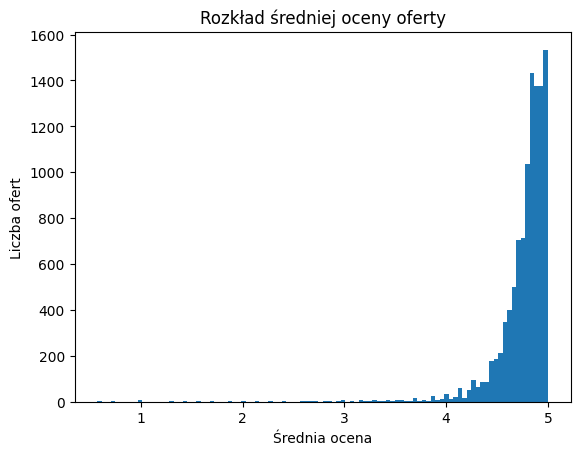

In [25]:
avg_rating = listings["avg_rating"]
print(f"Mean: {avg_rating.mean():.2f}")
print(f"Std: {avg_rating.std():.2f}")

plt.title("Rozkład średniej oceny oferty")
plt.xlabel("Średnia ocena")
plt.ylabel("Liczba ofert")
plt.hist(avg_rating, bins=100)
plt.plot()

### Atrybuty - listy


In [26]:
list_columns = [
    "host_verifications",
    "amenities",
]

In [27]:
listings = get_listings()
listings["amenities"].value_counts()

amenities
["Kitchen", "Heating", "Essentials", "Washer", "Wifi"]                                                                                                                                                                                                                                                                                                                                                        71
["Wine glasses", "Kitchen", "Dishes and silverware", "Clothing storage", "Stove", "Refrigerator", "Hot water", "Central heating", "Drying rack for clothing", "Cleaning products", "Dining table", "Shower gel", "Hangers", "Dedicated workspace", "Lock on bedroom door", "Essentials", "Washer", "Oven", "Bathtub", "Cooking basics", "Wifi", "Iron"]                                                       38
["Heating", "Washer", "Kitchen", "Wifi"]                                                                                                                                                    

In [28]:
def get_unique_values_in_list_column(df, column_name):
    all_values = set()
    for row in df[column_name]:
        if not isinstance(row, str):
            continue
        row_values = attribute_value_to_list(row)
        row_values = [a.strip() for a in row_values]
        all_values.update(row_values)

    return all_values


def attribute_value_to_list(value):
    if not isinstance(value, str):
        return []
    values = value.replace("[", "").replace("]", "").replace('"', "").replace("'", "").split(",")
    values = [a.strip() for a in values]
    return values


print(len(get_unique_values_in_list_column(listings, "host_verifications")))
print(len(get_unique_values_in_list_column(listings, "amenities")))

4
2454


In [29]:
def one_hot_encode_list_column(df, column_name):
    """One-hot encode list column"""
    all_values = get_unique_values_in_list_column(df, column_name)
    for value in all_values:
        df[f"{column_name}_{value}"] = df[column_name].apply(
            lambda x: True if value in attribute_value_to_list(x) else False)
    df.drop(columns=[column_name], inplace=True)
    return df

In [30]:
listings = one_hot_encode_list_column(listings, "host_verifications")
listings

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_verifications_,host_verifications_email,host_verifications_phone,host_verifications_work_email
0,2084992,https://www.nocarz.pl/rooms/2084992,20241221052002,2024-12-21,previous scrape,"Nice and cozy apartment in Kreuzberg, Graefekiez",Our cosy two room Apartment (70qm) in a vibrat...,"The apartment is situated on Fichtestrasse, wh...",https://a0.muscache.com/pictures/c4f2a8a8-34fa...,6302373,...,f,1,1,0,0,0.09,False,True,True,False
1,1123383729460847373,https://www.nocarz.pl/rooms/1123383729460847373,20241221052002,2024-12-21,city scrape,Furnished room in well equipped serviced apart...,Room in an apartment available. Apartment has ...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,206488801,...,f,3,1,2,0,NaN,False,True,True,False
2,1205255838613758737,https://www.nocarz.pl/rooms/1205255838613758737,20241221052002,2024-12-21,city scrape,Luxurous game room with private bath in X-Berg,Cozy private room in Berlin Mitte with private...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,50009901,...,f,1,0,1,0,9.53,False,True,True,False
3,8164759,https://www.nocarz.pl/rooms/8164759,20241221052002,2024-12-21,previous scrape,Beautiful single-room studio,Experience the “real Berlin” in our small and ...,In the area you can find lots of affordable ba...,https://a0.muscache.com/pictures/103988560/a5d...,42115726,...,f,1,1,0,0,0.01,False,True,True,False
4,18836877,https://www.nocarz.pl/rooms/18836877,20241221052002,2024-12-21,previous scrape,Unterkunft zentral in Berlin,"The accommodation has 3 rooms, however, is onl...",NaN,https://a0.muscache.com/pictures/452bf022-c9a9...,131184702,...,f,1,1,0,0,NaN,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979,1066742710842868324,https://www.nocarz.pl/rooms/1066742710842868324,20241221052002,2024-12-21,previous scrape,Cozy bedroom in a stylish house,NaN,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,125006999,...,f,3,0,3,0,0.82,False,True,True,False
13980,882524735229064604,https://www.nocarz.pl/rooms/882524735229064604,20241221052002,2024-12-21,city scrape,hornos - 1 bedroom apartment in kreuzberg,"Spectacular apartment in Eylauerstrasse, with ...",NaN,https://a0.muscache.com/pictures/prohost-api/H...,449692327,...,t,58,58,0,0,NaN,False,True,True,False
13981,1172288594718636022,https://www.nocarz.pl/rooms/1172288594718636022,20241221052002,2024-12-21,previous scrape,Deluxe Superior Accessible,This wheelchair accessible double room feature...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,570785536,...,t,6,0,6,0,NaN,False,True,True,False
13982,1233927040956879330,https://www.nocarz.pl/rooms/1233927040956879330,20241221052002,2024-12-21,previous scrape,Prenzlauerberg Berlin,Fully equipped apartment with large balcony in...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,3893392,...,f,2,2,0,0,NaN,False,True,True,False


### Atrybuty kategoryczne

In [31]:
listings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_verifications_,host_verifications_email,host_verifications_phone,host_verifications_work_email
0,2084992,https://www.nocarz.pl/rooms/2084992,20241221052002,2024-12-21,previous scrape,"Nice and cozy apartment in Kreuzberg, Graefekiez",Our cosy two room Apartment (70qm) in a vibrat...,"The apartment is situated on Fichtestrasse, wh...",https://a0.muscache.com/pictures/c4f2a8a8-34fa...,6302373,...,f,1,1,0,0,0.09,False,True,True,False
1,1123383729460847373,https://www.nocarz.pl/rooms/1123383729460847373,20241221052002,2024-12-21,city scrape,Furnished room in well equipped serviced apart...,Room in an apartment available. Apartment has ...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,206488801,...,f,3,1,2,0,NaN,False,True,True,False
2,1205255838613758737,https://www.nocarz.pl/rooms/1205255838613758737,20241221052002,2024-12-21,city scrape,Luxurous game room with private bath in X-Berg,Cozy private room in Berlin Mitte with private...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,50009901,...,f,1,0,1,0,9.53,False,True,True,False
3,8164759,https://www.nocarz.pl/rooms/8164759,20241221052002,2024-12-21,previous scrape,Beautiful single-room studio,Experience the “real Berlin” in our small and ...,In the area you can find lots of affordable ba...,https://a0.muscache.com/pictures/103988560/a5d...,42115726,...,f,1,1,0,0,0.01,False,True,True,False
4,18836877,https://www.nocarz.pl/rooms/18836877,20241221052002,2024-12-21,previous scrape,Unterkunft zentral in Berlin,"The accommodation has 3 rooms, however, is onl...",NaN,https://a0.muscache.com/pictures/452bf022-c9a9...,131184702,...,f,1,1,0,0,NaN,False,True,True,False


In [32]:
# candidates ?
categorical_columns = [
    "neighbourhood_group_cleansed",
    "property_type",
    "room_type",
]

In [33]:
print(len(listings["host_location"].unique()))
listings["host_location"].value_counts()

478


host_location
Berlin, Germany           9891
Germany                    159
Munich, Germany             80
Hamburg, Germany            59
Cologne, Germany            54
                          ... 
Chania, Greece               1
Aubervilliers, France        1
Forchtenberg, Germany        1
Eindhoven, Netherlands       1
Grambow, Germany             1
Name: count, Length: 477, dtype: int64

In [34]:
def extract_host_country(df):
    """Extract host country from host_location"""

    def extract_country_from_location(location: str):
        if not "," in location:
            return location

        state = location.split(",")[-1].strip()

        if len(state) == 2:
            return "United States"

        return state

    df["host_country"] = df["host_location"].apply(
        lambda x: extract_country_from_location(x) if isinstance(x, str) else x)
    return df

In [35]:
# Prawie tylko Niemcy, chyba nie warto
listings = extract_host_country(listings)
listings["host_country"].value_counts()

host_country
Germany           10657
United States        93
United Kingdom       75
Spain                64
France               60
                  ...  
Albania               1
Czechia               1
Tunisia               1
Morocco               1
Puerto Rico           1
Name: count, Length: 62, dtype: int64

In [36]:
print(listings["host_response_time"].value_counts())
print(listings["host_response_time"].unique())

host_response_time
within an hour        5374
within a few hours    1751
within a day          1131
a few days or more     400
Name: count, dtype: int64
[nan 'within an hour' 'within a few hours' 'within a day'
 'a few days or more']


In [37]:
def transform_host_response_time(df):
    """Transform host response time to a number"""
    #TODO adjust scale
    scale = {
        "within an hour": 1,
        "within a few hours": 2,
        "within a day": 3,
        "a few days or more": 4,
    }

    df["host_response_time"] = df["host_response_time"].apply(lambda x: scale.get(x, np.nan))
    return df

In [38]:
listings = get_listings()
listings = transform_host_response_time(listings)
print(listings["host_response_time"].value_counts())
print(listings["host_response_time"].isna().sum())

host_response_time
1.0    5374
2.0    1751
3.0    1131
4.0     400
Name: count, dtype: int64
5328


In [39]:
print(len(listings["host_neighbourhood"].unique()))  # Too many categories
print(len(listings["neighbourhood_cleansed"].unique()))  # Too many categories
print(len(listings["neighbourhood"].unique()))
print(len(listings["neighbourhood_group_cleansed"].unique()))

162
138
32
12


In [40]:
listings["neighbourhood"].value_counts()  # Useless

neighbourhood
Berlin, Germany                                6753
Berlin - Mitte, Germany                           3
Berlin, Be, Germany                               3
Berlin Charlottenburg, Berlin, Germany            3
Berlin, Prenzlauer Berg, Germany                  2
Friedrichshain, Berlin, Germany                   2
Berlin, BE, Germany                               1
Berlin, Deutschland, Germany                      1
Weissensee, Berlin, Germany                       1
Hoppegarten, Brandenburg, Germany                 1
Berlin, Zehlendorf, Germany                       1
Weissenhoher Strasse 14, Berlin, Germany          1
Berlin-Bohnsdorf, Germany                         1
Köpenick, Berlin, Germany                         1
Mitte, Berlin, Germany                            1
berlin, Berlin, Germany                           1
Berlin, Spandau, Germany                          1
Berlin Prenzlauer Berg , Berlin, Germany          1
Mitte/Tiergarten, Berlin, Germany                 

In [41]:
listings["neighbourhood_group_cleansed"].value_counts()  # Maybe useful

neighbourhood_group_cleansed
Friedrichshain-Kreuzberg    3052
Mitte                       2967
Pankow                      2161
Neukölln                    1595
Charlottenburg-Wilm.        1415
Tempelhof - Schöneberg       969
Treptow - Köpenick           600
Lichtenberg                  396
Steglitz - Zehlendorf        380
Reinickendorf                200
Spandau                      137
Marzahn - Hellersdorf        112
Name: count, dtype: int64

In [42]:
listings["property_type"].value_counts()

property_type
Entire rental unit                    7585
Private room in rental unit           3148
Entire condo                           761
Entire serviced apartment              399
Room in hotel                          340
Private room in condo                  289
Entire loft                            261
Private room in home                   197
Entire home                            183
Entire guesthouse                       69
Room in boutique hotel                  64
Private room in hostel                  56
Private room in bed and breakfast       51
Private room in loft                    50
Room in aparthotel                      42
Entire vacation home                    42
Houseboat                               39
Room in serviced apartment              39
Private room in townhouse               34
Private room                            33
Private room in serviced apartment      31
Entire townhouse                        31
Shared room in hostel                   

In [43]:
def group_property_types(df):
    """Group together similar property types"""

    def transform(property_type: str):
        if "entire rental unit" in property_type.lower():
            return "entire rental unit"
        elif "room" in property_type.lower():
            return "room"
        elif "apartment" in property_type.lower():
            return "apartment"
        elif "home" in property_type.lower():
            return "home"
        elif "condo" in property_type.lower():
            return "condo"
        else:
            return "other"

    df["property_type"] = df["property_type"].apply(lambda x: transform(x) if isinstance(x, str) else x)
    return df

In [44]:
listings = get_listings()
listings = group_property_types(listings)
listings["property_type"].value_counts()

property_type
entire rental unit    7585
room                  4497
condo                  761
other                  496
apartment              399
home                   246
Name: count, dtype: int64

In [45]:
listings["room_type"].value_counts()

room_type
Entire home/apt    9515
Private room       4306
Hotel room          117
Shared room          46
Name: count, dtype: int64

In [46]:
listings["bathrooms_text"].value_counts()

bathrooms_text
1 bath               8665
1 shared bath        2024
2 baths               944
1 private bath        921
1.5 baths             699
1.5 shared baths      200
2 shared baths        136
2.5 baths              98
3 baths                62
Half-bath              40
0 baths                37
Shared half-bath       32
0 shared baths         24
3 shared baths         16
Private half-bath      14
3.5 baths              13
4 shared baths         13
2.5 shared baths       13
4 baths                11
6 baths                 4
8.5 shared baths        3
4.5 baths               2
27 baths                1
15 baths                1
8 baths                 1
5 baths                 1
8.5 baths               1
8 shared baths          1
Name: count, dtype: int64

In [47]:
def extract_num_bathrooms(df):
    def parse_bathroom(text):
        text = str(text).lower()
        match = re.search(r'(\d+\.?\d*)', text)
        if match:
            return float(match.group(1))
        elif 'half' in text:
            return 0.5
        else:
            return None  

    df['num_bathrooms'] = df['bathrooms_text'].apply(parse_bathroom)
    return df

In [48]:
def extract_is_shared_from_bathrooms_text(df):
    """Extract is_shared from bathrooms_text column"""
    extract_is_shared = lambda txt: 1 if "shared" in txt.lower() else 0
    df["is_shared_bathroom"] = df["bathrooms_text"].apply(lambda x: extract_is_shared(x) if isinstance(x, str) else x)
    df = df.drop(columns=["bathrooms_text"])
    return df

In [49]:
def categorical_columns_one_hot_encoding(df):
    """One-hot encode categorical columns"""
    categorical_columns = [
        "neighbourhood_group_cleansed",
        "property_type",
        "room_type",
        "is_shared_bathroom",
    ]

    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
    return df

## Inne atrybuty do przekształcenia

In [50]:
def transform_host_since(df):
    """Transform timestamp to number of years since"""
    current_year = datetime.now().year

    extract_years_since = lambda timestamp: current_year - int(timestamp.split("-")[0])

    df["host_since"] = df["host_since"].apply(lambda x: extract_years_since(x) if isinstance(x, str) else x)
    return df

<Axes: xlabel='host_since'>

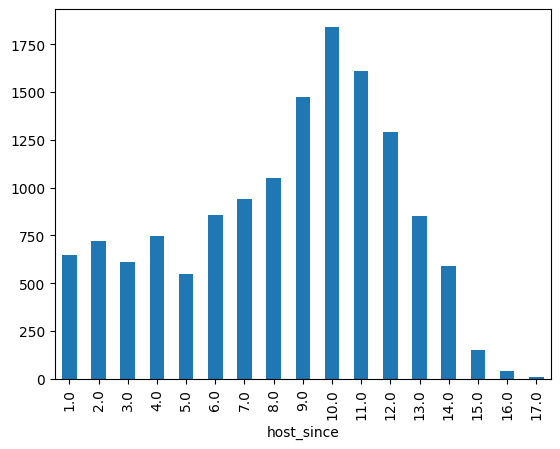

In [51]:
listings = get_listings()
listings = transform_host_since(listings)
listings["host_since"].value_counts().sort_index().plot(kind="bar")

In [52]:
listings["host_response_rate"].value_counts()

host_response_rate
100%    6464
70%      396
0%       266
90%      237
99%      137
50%       98
86%       93
80%       89
95%       85
98%       84
94%       77
67%       66
96%       65
97%       56
60%       50
75%       40
93%       37
33%       26
89%       21
40%       20
91%       20
71%       17
83%       15
88%       14
10%       14
92%       14
20%       11
25%       11
30%       11
82%       10
78%       10
85%        9
29%        9
48%        9
57%        8
84%        8
63%        7
72%        7
87%        6
76%        5
56%        4
46%        3
14%        3
43%        2
68%        2
17%        2
38%        2
55%        2
62%        2
13%        2
9%         1
8%         1
22%        1
15%        1
53%        1
18%        1
12%        1
11%        1
64%        1
27%        1
Name: count, dtype: int64

In [53]:
listings["host_acceptance_rate"].value_counts()

host_acceptance_rate
100%    2987
99%     1056
0%       505
98%      351
96%      280
        ... 
16%        4
3%         3
5%         1
2%         1
1%         1
Name: count, Length: 101, dtype: int64

In [54]:
def transform_percentage_to_number(df):
    """Transform percentage to number from range [0, 1]"""
    percentage_columns = [
        "host_response_rate",
        "host_acceptance_rate",
    ]
    transform_percentage = lambda x: float(x.replace("%", "")) / 100

    for c in percentage_columns:
        df[c] = df[c].apply(lambda x: transform_percentage(x) if isinstance(x, str) else x)
    return df

In [55]:
listings = get_listings()
price = listings["price"]
print(len(price))
price.map(lambda p: str(type(p))).value_counts()

13984


price
<class 'str'>      8990
<class 'float'>    4994
Name: count, dtype: int64

In [56]:
def transform_price(df):
    """Transform price column to float"""
    transform_string_price = lambda p: float(p.replace("$", "").replace(",", ""))

    df["price"] = df["price"].apply(lambda p: transform_string_price(p) if isinstance(p, str) else p)
    return df

In [57]:
df = get_listings()
df = transform_price(df)
df["price"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 13984 entries, 0 to 13983
Series name: price
Non-Null Count  Dtype  
--------------  -----  
8990 non-null   float64
dtypes: float64(1)
memory usage: 109.4 KB


### Dodatkowy atrybut - średnia ocena pozostałych ogłoszeń hosta 


In [58]:
def add_average_rating_by_host(df):
    """Add average rating by host"""
    df["avg_rating_by_host"] = df.groupby("host_id")["avg_rating"].transform("mean")
    return df


df = get_listings()
df = aggregate_rating_columns(df)
df = add_average_rating_by_host(df)
print(df["avg_rating_by_host"].info())

print(len(df[(df["avg_rating_by_host"].isna()) & (df["avg_rating"].isna())]))
print(len(df[(df["avg_rating_by_host"].notna()) & (df["avg_rating"].isna())]))
# Helps with about 20% of missing values


<class 'pandas.core.series.Series'>
RangeIndex: 13984 entries, 0 to 13983
Series name: avg_rating_by_host
Non-Null Count  Dtype  
--------------  -----  
11820 non-null  float64
dtypes: float64(1)
memory usage: 109.4 KB
None
2164
1114


## Normalizacja atrybutów liczbowych

In [59]:
df = get_listings()
df = drop_useless_columns(df)
df = drop_fulltext_columns(df)
df = transform_binary_columns(df)
df = aggregate_rating_columns(df)
df = transform_price(df)
df = transform_host_response_time(df)
df = extract_is_shared_from_bathrooms_text(df)
df = group_property_types(df)
df = categorical_columns_one_hot_encoding(df)
df = transform_host_since(df)
df = transform_percentage_to_number(df)
df = one_hot_encode_list_column(df, "host_verifications")
df = add_average_rating_by_host(df)
df = df.drop(columns=["host_id"])  # after adding avg_rating_by_host

# Not all should be normalized!
print(f"Numerical columns: {df.select_dtypes(include=["number"]).columns}")

print(f"Mean before normalization: {df["avg_rating_by_host"].mean()}")
print(f"Stdev before normalization: {df["avg_rating_by_host"].std()}")


def normalize_numerical_columns(df):
    """Standardize numerical columns to have mean 0 and std 1"""

    numerical_columns = [
        "maximum_nights",
        "minimum_minimum_nights",
        "maximum_minimum_nights",
        "minimum_maximum_nights",
        "maximum_maximum_nights",
        "minimum_nights_avg_ntm",
        "maximum_nights_avg_ntm",
        "availability_30",
        "availability_60",
        "availability_90",
        "availability_365",
        "calculated_host_listings_count",
        "calculated_host_listings_count_entire_homes",
        "calculated_host_listings_count_private_rooms",
        "calculated_host_listings_count_shared_rooms",
        "price",
        "avg_rating",
        "avg_rating_by_host",
    ]
    scaler = StandardScaler()

    for c in numerical_columns:
        df[c] = scaler.fit_transform(df[[c]])

    return df


df = normalize_numerical_columns(df)

print(f"Mean after normalization: {df["avg_rating_by_host"].mean()}")
print(f"Stdev after normalization: {df["avg_rating_by_host"].std()}")


Numerical columns: Index(['host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'avg_rating',
       'avg_rating_by_host'],
      dtype='object')
Mean before normalization: 4.727575791770125
Stdev before normalizati

## Final transformations

In [83]:
def transform_listings(df, normalize_numerical: bool = True):
    df = drop_useless_columns(df)
    df = drop_fulltext_columns(df)
    df = transform_binary_columns(df)
    df = aggregate_rating_columns(df)
    df = transform_price(df)
    df = transform_host_response_time(df)
    df = extract_num_bathrooms(df)
    df = extract_is_shared_from_bathrooms_text(df)
    df = group_property_types(df)
    df = categorical_columns_one_hot_encoding(
        df
    )  # after extracting is_shared_bathroom and grouping property types!
    df = transform_host_since(df)
    df = transform_percentage_to_number(df)
    df = one_hot_encode_list_column(df, "host_verifications")
    df = add_average_rating_by_host(df)
    df = df.drop(columns=["host_id"])  # after adding avg_rating_by_host

    if normalize_numerical:
        df = normalize_numerical_columns(df)
    return df


In [61]:
listings = get_listings()
listings = transform_listings(listings)

In [62]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13984 entries, 0 to 13983
Data columns (total 59 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   host_since                                             13975 non-null  float64
 1   host_response_time                                     8656 non-null   float64
 2   host_response_rate                                     8656 non-null   float64
 3   host_acceptance_rate                                   9447 non-null   float64
 4   host_is_superhost                                      13984 non-null  int64  
 5   host_listings_count                                    13975 non-null  float64
 6   host_total_listings_count                              13975 non-null  float64
 7   host_has_profile_pic                                   13984 non-null  int64  
 8   host_identity_verified                        

In [63]:
listings

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,accommodates,...,property_type_room,room_type_Hotel room,room_type_Private room,room_type_Shared room,is_shared_bathroom_1.0,host_verifications_,host_verifications_email,host_verifications_phone,host_verifications_work_email,avg_rating_by_host
0,12.0,NaN,NaN,NaN,0,1.0,1.0,1,1,2,...,False,False,False,False,False,False,True,True,False,0.560875
1,7.0,1.0,1.0,0.58,0,7.0,7.0,1,1,2,...,True,False,True,False,True,False,True,True,False,NaN
2,10.0,1.0,1.0,1.00,1,1.0,1.0,1,1,2,...,True,False,True,False,False,False,True,True,False,0.787688
3,10.0,NaN,NaN,NaN,0,1.0,3.0,1,1,2,...,False,False,False,False,False,False,True,True,False,-1.461541
4,8.0,NaN,NaN,NaN,0,1.0,1.0,1,1,3,...,False,False,False,False,False,False,True,True,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979,8.0,1.0,1.0,0.97,1,3.0,3.0,1,1,1,...,True,False,True,False,False,False,True,True,False,0.633329
13980,3.0,1.0,1.0,1.00,0,58.0,59.0,1,1,2,...,False,False,False,False,False,False,True,True,False,-5.478020
13981,1.0,NaN,NaN,NaN,0,6.0,6.0,1,1,2,...,True,False,True,False,False,False,True,True,False,NaN
13982,13.0,NaN,NaN,NaN,0,2.0,2.0,1,1,2,...,False,False,False,False,False,False,True,True,False,-0.407805


## Brakujące wartości atrybutów

* Patrzymy na podzbiór gdzie brakuje oceny - to będzie nasz zbiór treningowy
* Brak price, beds, bathrooms występuje jednocześnie
* Jest mocno skorelowany z brakami w reszcie atrybutów

In [64]:
listings = listings[listings["avg_rating"].notna()]
missing_ratio = round(listings.isna().sum() / len(listings), 2)
missing_ratio[missing_ratio > 0].sort_values(ascending=False)

price                   0.36
beds                    0.36
bathrooms               0.36
host_response_time      0.34
host_response_rate      0.34
host_acceptance_rate    0.27
bedrooms                0.15
dtype: float64

In [65]:
listings_no_price = listings[listings["price"].isna()]
print(len(listings_no_price))
missing_ratio = round(listings_no_price.isna().sum() / len(listings_no_price), 2)
missing_ratio[missing_ratio > 0].sort_values(ascending=False)

3809


price                   1.00
beds                    1.00
bathrooms               1.00
host_response_time      0.78
host_response_rate      0.78
host_acceptance_rate    0.68
bedrooms                0.41
dtype: float64

In [66]:
listings_no_beds = listings[listings["beds"].isna()]
missing_ratio = round(listings_no_beds.isna().sum() / len(listings_no_beds), 2)
missing_ratio[missing_ratio > 0].sort_values(ascending=False)

beds                    1.00
bathrooms               0.99
price                   0.99
host_response_time      0.78
host_response_rate      0.78
host_acceptance_rate    0.67
bedrooms                0.41
dtype: float64

In [67]:
listings = get_listings()
len(listings)

13984

In [68]:
listings = transform_listings(get_listings())
listings.select_dtypes(include=["number"]).columns

Index(['host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'avg_rating',
       'num_bathrooms', 'avg_rating_by_host'],
      dtype='object')


## Analiza korelacji atrybutów liczbowych i średniej oceny

avg_rating_by_host                              0.802230
calculated_host_listings_count                 -0.209784
calculated_host_listings_count_entire_homes    -0.197717
availability_365                               -0.164865
availability_30                                -0.127890
availability_60                                -0.120489
availability_90                                -0.115203
calculated_host_listings_count_private_rooms   -0.115010
maximum_minimum_nights                         -0.106261
maximum_nights                                 -0.067692
minimum_minimum_nights                         -0.045542
minimum_nights_avg_ntm                         -0.041758
price                                          -0.039740
calculated_host_listings_count_shared_rooms    -0.023817
num_bathrooms                                   0.023650
minimum_maximum_nights                          0.000220
maximum_nights_avg_ntm                          0.000220
maximum_maximum_nights         

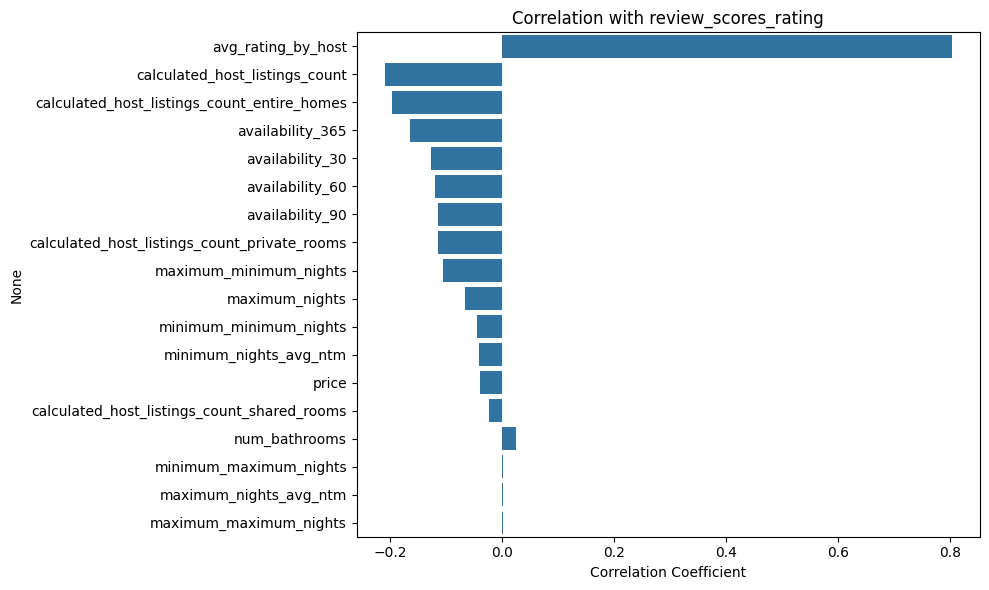

In [69]:
numerical_columns = [
    "maximum_nights",
    "minimum_minimum_nights",
    "maximum_minimum_nights",
    "minimum_maximum_nights",
    "maximum_maximum_nights",
    "minimum_nights_avg_ntm",
    "maximum_nights_avg_ntm",
    "availability_30",
    "availability_60",
    "availability_90",
    "availability_365",
    "calculated_host_listings_count",
    "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms",
    "calculated_host_listings_count_shared_rooms",
    "price",
    "avg_rating_by_host",
    "num_bathrooms"
]
target = "avg_rating"
df = transform_listings(get_listings())

non_empty = df[[target] + numerical_columns].dropna()
corr_matrix = non_empty.corr()
correlations_with_target = corr_matrix[target].drop(target).sort_values(key=abs, ascending=False)
print(correlations_with_target)

plt.figure(figsize=(10, 6))
sns.barplot(x=correlations_with_target.values, y=correlations_with_target.index)
plt.title('Correlation with review_scores_rating')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()




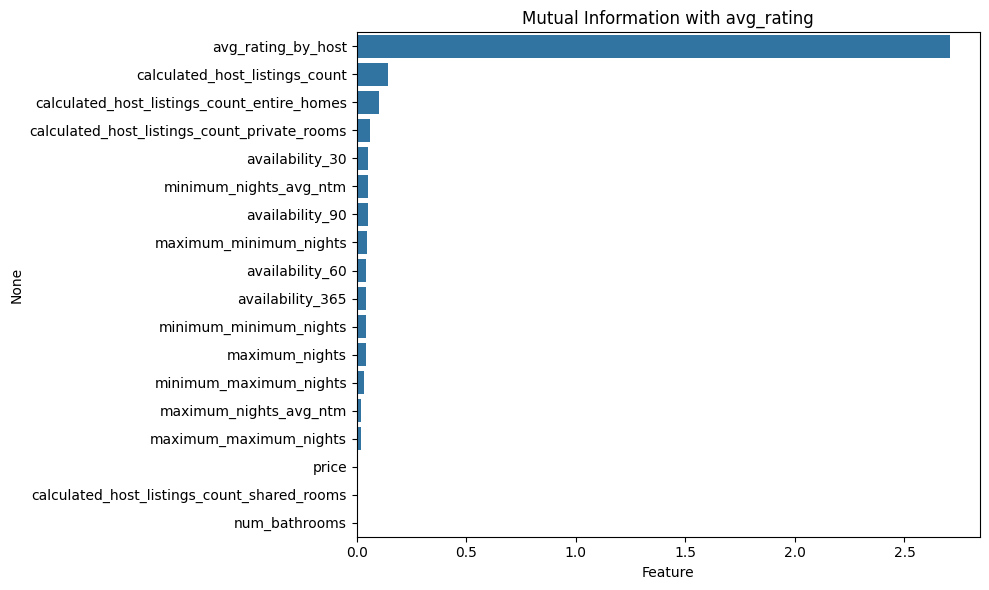

avg_rating_by_host                              2.709162
calculated_host_listings_count                  0.144839
calculated_host_listings_count_entire_homes     0.102992
calculated_host_listings_count_private_rooms    0.062053
availability_30                                 0.053629
minimum_nights_avg_ntm                          0.051913
availability_90                                 0.051599
maximum_minimum_nights                          0.046617
availability_60                                 0.043887
availability_365                                0.043633
minimum_minimum_nights                          0.043626
maximum_nights                                  0.041204
minimum_maximum_nights                          0.035078
maximum_nights_avg_ntm                          0.022076
maximum_maximum_nights                          0.020467
price                                           0.001069
calculated_host_listings_count_shared_rooms     0.000000
num_bathrooms                  

In [70]:
X = non_empty[numerical_columns]
y = non_empty[target]
mi = mutual_info_regression(X, y)
mi = pd.Series(mi, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=mi.values, y=mi.index)
plt.title('Mutual Information with avg_rating')
plt.xlabel('Mutual Information')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()
print(mi)

## Analiza rozkładów interesujących atrybutów
Za interesujące uważamy atrybuty o najwyższym współczynniku korelacji i wzajemnej informacji

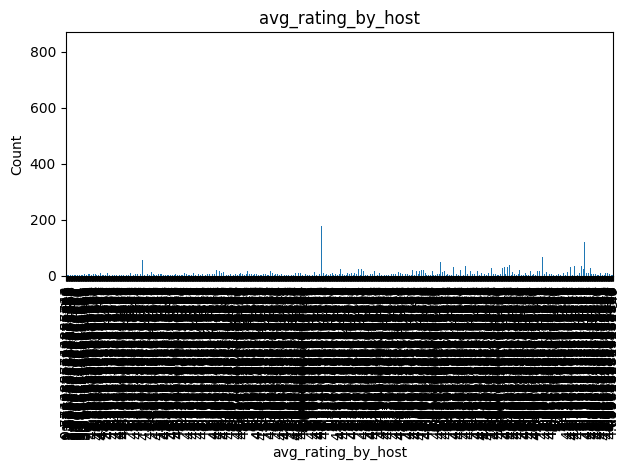

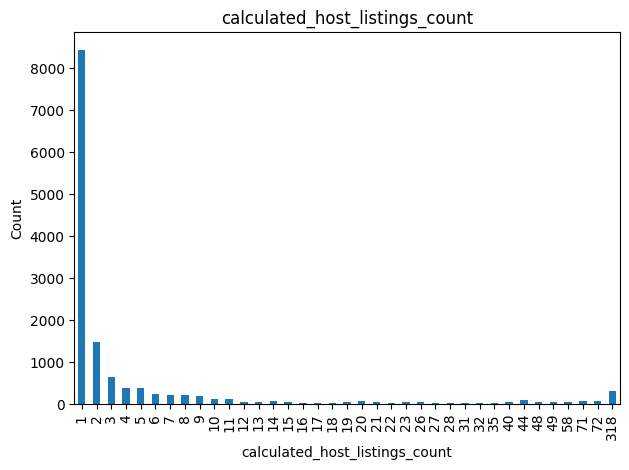

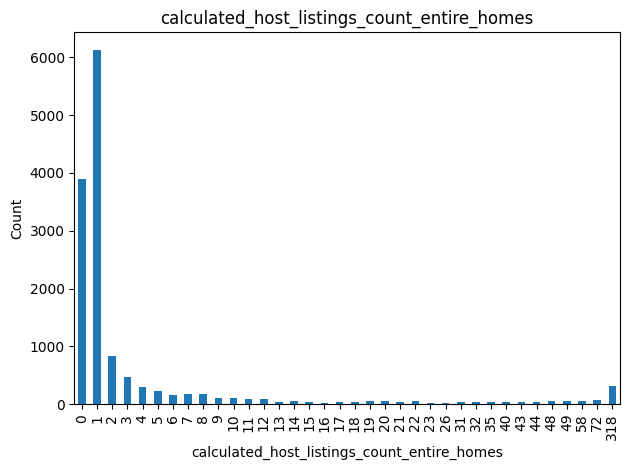

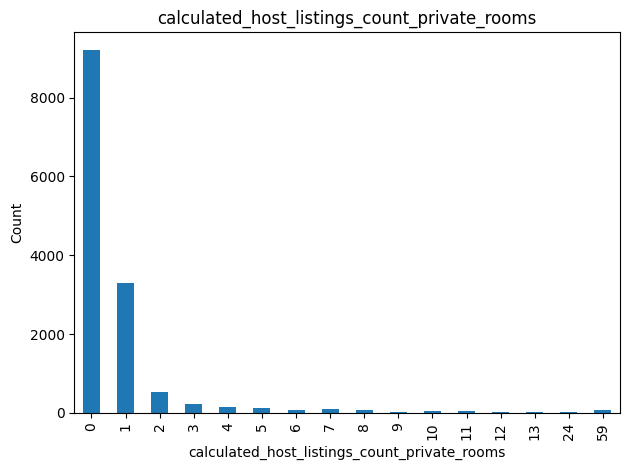

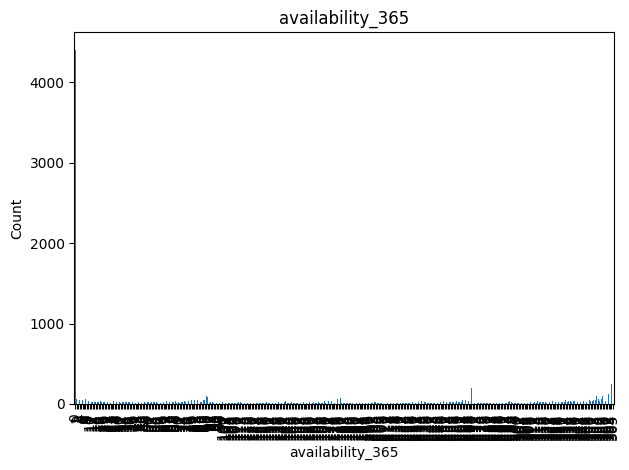

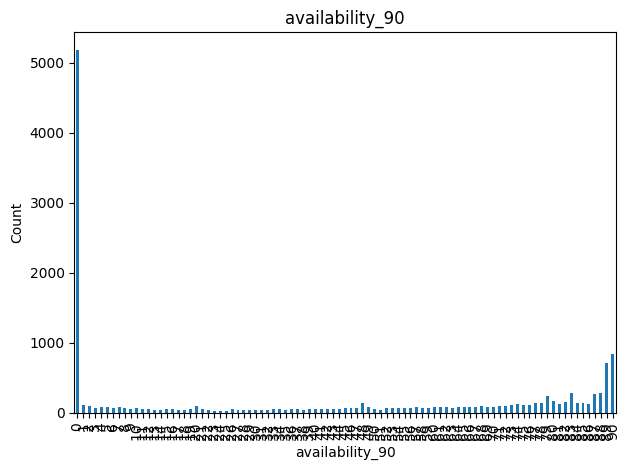

0        4.897143
1             NaN
2        4.965714
3        4.285714
4             NaN
           ...   
13979    4.919048
13980    3.071429
13981         NaN
13982    4.604286
13983         NaN
Name: avg_rating_by_host, Length: 13984, dtype: float64

In [92]:
interesting_cols = ["avg_rating_by_host", "calculated_host_listings_count", "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms", "availability_365", "availability_90"]

def is_categorical(series, threshold=10):
    # Explicitly check for object, bool, or category types
    if series.dtype == "object" or series.dtype.name == "category" or series.dtype == "bool":
        return True
    # Optionally treat numerics with low cardinality as categorical
    elif pd.api.types.is_numeric_dtype(series):
        return series.nunique() < threshold
    return False


for col in interesting_cols:
    if is_categorical(listings[col]):
        kind = "bar"
    else:
        kind = "line"

    kind = "bar"
    
    plt.figure()
    listings[col].value_counts().sort_index().plot(kind=kind)
    plt.title(col)  
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


listings = transform_listings(get_listings(), normalize_numerical=False)
listings["calculated_host_listings_count_private_rooms"]
listings["avg_rating_by_host"]



In [89]:
print(f"Mean: {listings["avg_rating_by_host"].mean()}")
print(f"Std: {listings["avg_rating_by_host"].std()}")

Mean: 4.727575791770125
Std: 0.30233865196953147



### Obserwacje
* `avg_rating_by_host` - rozkład bardzo podobny do kolumny docelowej
* znacząca większość ogłaszających ma jedno ogłoszenie

## Wstępny format danych wejściowych do modelu

In [ ]:
listings = transform_listings(get_listings())

print(listings.columns)
listings.head()


Index(['host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'avg_rating',
       'num_bathrooms',
       'neighbourhood_group_cleansed_Friedrichshain-Kreuzberg',
       'neighbourhood_group_cleansed_Lichtenberg',
 

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,accommodates,...,property_type_room,room_type_Hotel room,room_type_Private room,room_type_Shared room,is_shared_bathroom_1.0,host_verifications_,host_verifications_email,host_verifications_phone,host_verifications_work_email,avg_rating_by_host
0,12.0,NaN,NaN,NaN,0,1.0,1.0,1,1,2,...,False,False,False,False,False,False,True,True,False,4.897143
1,7.0,1.0,1.0,0.58,0,7.0,7.0,1,1,2,...,True,False,True,False,True,False,True,True,False,NaN
2,10.0,1.0,1.0,1.00,1,1.0,1.0,1,1,2,...,True,False,True,False,False,False,True,True,False,4.965714
3,10.0,NaN,NaN,NaN,0,1.0,3.0,1,1,2,...,False,False,False,False,False,False,True,True,False,4.285714
4,8.0,NaN,NaN,NaN,0,1.0,1.0,1,1,3,...,False,False,False,False,False,False,True,True,False,NaN
